# Modeling the Spread of Misinformation in Social Networks using Graph Theory.



## Introduction
In the age of digital communication, social media serves as the main platform for the exchange of information. However, as social media platforms have matured and become more popular, they have created new breeding grounds for the spread of harmful misinformation and disinformation campaigns. This notebook aims to model the spread of misinformation in social networks (e.g., Twitter, Facebook, Reddit, etc.) using graph theory. By representing social networks as graphs, it is possible to simulate and analyze how misinformation propagates through these networks, identify key nodes (influencers, bad actors, etc.), and identify possible strategies to mitigate the spread of misinformation and reduce the impact of disinformation campaigns.

### Initial Setup
Import the necessary libraries and set up the environment for graph modeling and analysis.

In [2]:
import random
from typing import Callable, Optional, Any, Dict, List
import numpy as np

import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.animation import FuncAnimation
from matplotlib.artist import Artist
from matplotlib.colors import to_rgba
from networkx import draw_networkx_edges


### Example Graph

In [ ]:
G = nx.barabasi_albert_graph(200, 2)
nx.draw(G, node_size=50)

As you can see, the graph represents a fairly basic social network where every node (person) is connected with a few other nodes (friends). The Barabási-Albert model is used because it has *Preferential attachment* and seems to accurately represent the formation of *hubs* (influential persons/platforms) in real-world social networks.

# Basic Simulation of Misinformation Spread (SI Model)

This simulation is using a **Competing SI (Competing Spread of Information) model** to observe the spread of two ideas ('*Truth*' and '*Misinformation*') across a Barabasi-Albert network of **100** nodes.
***
### The model is initialized with the following conditions:

$N$ = **100** (number of nodes) <br>
$M$ = **3** (minimum degree of each node)

**Spread Probabilities (per time step)**:
**Normal Nodes** → 0.01%
**Influencer Nodes** → 0.05%
**Good Actors** → 0.025%
**Bad Actors** → 0.025%

**Network**: All (**non-spreading**) nodes begin as 'Susceptible'

**Seeding**: a small and equal number of '*Good Actors*' (spreading truth) and '*Bad Actors*' (spreading misinformation) are randomly assigned among normal nodes. They act as the sources of truth and misinformation/disinformation, respectively. Finally, two high-degree (top 75th percentile) nodes are designated as '*Influencers,' they are meant to spread information faster than normal nodes.

In [ ]:
%matplotlib notebook
# Define node states
node_roles = {
    'NORMAL': {
        'convincing_power': 0.01,
        'shape': 'o',
        'base_size': 50,
    },
    'INFLUENCER': {
        'convincing_power': 0.05,
        'shape': 'o',
        'base_size': 75,
    },
    'GOOD_ACTOR': {
        'convincing_power': 0.025,
        'shape': '^',
        'base_size': 100,
    },
    'BAD_ACTOR': {
        'convincing_power': 0.025,
        'shape': 'v',
        'base_size': 100,
    }
}

# Define the colors for each node belief easier visualization.
color_map = {
    'SUSCEPTIBLE': 'gray',
    'SUSCEPTIBLE_INFLUENCER': 'yellow',
    'MISINFORMATION_INFLUENCER': 'lightred',
    'TRUTH_INFLUENCER': 'lightblue',
    'MISINFORMATION': 'red',
    'TRUTH': 'green',
}

# Initialize the Graph
def setup_graph(
    N: int = 100,
    M: int = 3,
    seed: Optional[int] = None,
    GOOD_ACTORS_CAP: int = 2,
    BAD_ACTORS_CAP: int = 2,
    INFLUENCER_CAP: int = 2,
    popularity_condition: Optional[Callable[[int, int], bool]] = None,
    intervene: Optional[bool] = False
) -> nx.Graph:
    """
    Create a Barabási–Albert graph and annotate nodes with roles/beliefs.
    popularity_condition: Callable[[degree, highest_degree], bool]
      If None, defaults to `degree > highest_degree * 0.75`.
    """
    if seed is None:
        seed = random.randint(0, 100)

    G = nx.barabasi_albert_graph(n=N, m=M, seed=seed)

    # Initialize node attributes
    for node in G.nodes():
        G.nodes[node]['role'] = 'NORMAL'
        G.nodes[node]['belief'] = 'SUSCEPTIBLE'

    # Determine degrees and highest degree
    all_degrees = [d for _, d in G.degree()]
    highest_degree = max(all_degrees) if all_degrees else 0

    # Set the default popularity_condition now that highest_degree is known
    if popularity_condition is None:
        popularity_condition = lambda degree, highest: degree > (highest * 0.75)

    influencers = []
    # Mark influencers
    for node, degree in G.degree():
        if popularity_condition(degree, highest_degree):
            if len(influencers) >= INFLUENCER_CAP:
                break
            G.nodes[node]['role'] = 'INFLUENCER'
            influencers.append(node)


    # Randomly assign good/bad actors
    normal_nodes = [n for n in G.nodes() if G.nodes[n]['role'] == 'NORMAL']
    if intervene:
        normal_close_nodes = nx.single_source_shortest_path_length(G, influencers[random.randint(0, len(influencers)-1)], cutoff=D_SEPARATION)
        for i in range(min(GOOD_ACTORS_CAP, len(normal_close_nodes))):
            node_to_assign = normal_close_nodes.popitem()[0]
            G.nodes[node_to_assign]['role'] = 'GOOD_ACTOR'
            G.nodes[node_to_assign]['belief'] = 'TRUTH'
    else:
        for i in range(min(GOOD_ACTORS_CAP, len(normal_nodes))):
            node_to_assign = normal_nodes.pop()
            G.nodes[node_to_assign]['role'] = 'GOOD_ACTOR'
            G.nodes[node_to_assign]['belief'] = 'TRUTH'

    for i in range(min(BAD_ACTORS_CAP, len(normal_nodes))):
        node_to_assign = normal_nodes.pop()
        G.nodes[node_to_assign]['role'] = 'BAD_ACTOR'
        G.nodes[node_to_assign]['belief'] = 'MISINFORMATION'

    # Optional: compute node_shapes, node_sizes, node_colors if needed by caller
    # (relies on a global `node_roles` and `color_map` if present)
    try:
        node_shapes = [node_roles[G.nodes[n]['role']]['shape'] for n in G.nodes()]
        node_sizes = []
        for n in G.nodes():
            role = G.nodes[n]['role']
            size = node_roles[role]['base_size']
            if role == 'INFLUENCER':
                size += (G.degree[n] * 10)
            node_sizes.append(size)
        node_colors = [color_map[G.nodes[n]['belief']] for n in G.nodes()]
        # attach for convenience
        G.graph['node_shapes'] = node_shapes
        G.graph['node_sizes'] = node_sizes
        G.graph['node_colors'] = node_colors
    except Exception:
        # If globals not defined, skip the convenience attributes
        pass

    return G

def simulate_step(graph: nx.Graph,
                  roles_dict: Dict[str, Dict[str, Any]],
                  history: List[Dict[str, int]] = None
                  ):

    # We collect nodes to update *after* looping
    # This prevents a node from being infected and spreading in the same step
    nodes_to_update = {} # Stores {node_to_infect: new_belief}
    counts = {'MISINFORMATION': 0, 'TRUTH': 0, 'SUSCEPTIBLE': 0}

    for node in graph.nodes():
        current_belief = graph.nodes[node]['belief']

        # 1. Check if this node is a spreader
        # NOTE: add immune condition later.
        if current_belief == 'MISINFORMATION' or current_belief == 'TRUTH':

            # 2. Get the spreader's convincing power from their role
            role = graph.nodes[node]['role']
            power = roles_dict[role]['convincing_power']

            # 3. Find susceptible neighbors
            for neighbor in graph.neighbors(node):
                if graph.nodes[neighbor]['belief'] == 'SUSCEPTIBLE':

                    # 4. Roll the dice
                    if random.random() < power:

                        # We only update if they haven't been marked by another belief
                        if neighbor not in nodes_to_update:
                            nodes_to_update[neighbor] = current_belief

    # 5. Apply all updates at once
    for node, new_belief in nodes_to_update.items():
        # Only update if they are still susceptible (first-come, first-served)
        if graph.nodes[node]['belief'] == 'SUSCEPTIBLE':
            graph.nodes[node]['belief'] = new_belief


    for node in G.nodes():
        counts[G.nodes[node]['belief']] += 1
    history.append(counts)

    return nodes_to_update

# def intervention(graph: nx.Graph, num_to_add: int):
#     """
#     Introduces an intervention by converting a number of susceptible nodes to truth spreaders.
#     :param graph: Networkx Graph
#     :param num_to_add: Number of susceptible nodes to convert to truth spreaders.
#     :return: Nodes Changed in {node_id: new_belief} | None
#     """
#     susceptible_nodes = [node for node in graph.nodes() if graph.nodes[node]['belief'] == 'SUSCEPTIBLE']
#     if not susceptible_nodes:
#         print("No susceptible nodes found. Cannot introduce intervention.")
#         return None
#     # {node_id: new_belief} basically the same as nodes changed in simulate_step
#     nodes_changed = {}
#     random.shuffle(susceptible_nodes)
#
#     for i in range(min(num_to_add, len(susceptible_nodes))):
#         node = susceptible_nodes[i]
#         nodes_changed[node] = 'TRUTH'
#
#
#     return nodes_changed


def find_collection_for_node(node_map, role, node):
    """
    Given node_map[role] == { collection: { node: idx, ... }, ... }
    return (collection, idx) or (None, None) if not found.
    """
    role_dict = node_map.get(role)
    if not role_dict:
        return None, None
    for collection, node_to_idx in role_dict.items():
        idx = node_to_idx.get(node)
        if idx is not None:
            return collection, idx
    return None, None

def update_node_color(node_id: int, node_data: Dict[str, str], belief: str):
    """
    Update the color of each node infected with a new belief by changing its facecolor.
    :param node_id: Index of the node in graph.nodes()
    :param node_data: Node data dictionary from graph.nodes[node_id]
    :param belief: New belief of the node to be updated.
    :return: Artist Collection of updated facecolors for the node.
    """
    collection, idx = find_collection_for_node(node_map, node_data['role'], node_id)
    if collection is None:
        return None
    # This needs to be converted to a tuple of RGBA values so that it has compatibility with
    # matplotlib's facecolor array.
    belief_color = to_rgba(color_map.get(belief, '#999999'))

    # NOTE: There could be cases where the face colors are in just like one array,
    # and to be honest with you, I cannot bother to read the docs on that, so imma just pretend
    # it doesn't matter.

    fc = collection.get_facecolor()
    fc[idx] = belief_color

    collection.set_facecolor(fc)
    return collection

node_map = {}

def create_node_map(role_name, collection, nodelist):
    """
    Map: node_map[role_name][collection] = { node: index_in_collection, ... }
    """
    node_to_idx = {node: i for i, node in enumerate(nodelist)}
    node_map.setdefault(role_name, {})[collection] = node_to_idx

N = 100
M = 3
GOOD_ACTORS_CAP = 2
BAD_ACTORS_CAP = 2
INFLUENCER_CAP = 2
D_SEPARATION = 3

# Setup Graph and layout
G = setup_graph(N=N, M=M, seed=None, GOOD_ACTORS_CAP=GOOD_ACTORS_CAP, BAD_ACTORS_CAP=BAD_ACTORS_CAP)
pos = nx.spring_layout(G)

# Create figures and axes for animation
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,12))

# Define lines for each belief state
line_sus, = ax2.plot([], [], label='Susceptible', color='gray', linestyle='--')
line_tru, = ax2.plot([], [], label='Truth', color='green', marker='.')
line_mis, = ax2.plot([], [], label='Misinformation', color='red', marker='.')

title_obj = None
init_artists = None

history = []

def init():
    global title_obj, init_artists, line_mis, line_tru, line_sus

    draw_networkx_edges(G, pos, ax=ax1, alpha=0.2)

    node_sizes = G.graph['node_sizes']
    node_colors = G.graph['node_colors']

    node_indices = {node: i for i, node in enumerate(G.nodes())}

    init_artists = []
    # NORMAL, INFLUENCER, GOOD_ACTOR, BAD_ACTOR, Title <--- In that order.
    # NOTE: The order doesnt matter anymore since I am mapping collections with their respective roles.
    for role_name, attributes in node_roles.items():
        shape = attributes['shape']
        # makes a list of nodes with the same role.
        nodelist = [node for node in G.nodes() if G.nodes[node]['role'] == role_name]
        if not nodelist:
            continue

        # I use indices to find the corresponding index for each node in nodelist to then find its size and color,
        # then put that information into a list of size and color for each node.
        size_list = [node_sizes[node_indices[n]] for n in nodelist]
        color_list = [node_colors[node_indices[n]] for n in nodelist]

        collection = nx.draw_networkx_nodes(G, pos,
                               ax=ax1,
                               nodelist=nodelist,
                               node_shape=shape,
                               node_color=color_list,
                               node_size=size_list)
        create_node_map(role_name, collection, nodelist)
        init_artists.append(collection)

    title_obj = ax1.set_title(f"Simulation Step 0 / {simulation_steps}")
    ax1.axis('off')
    init_artists.append(title_obj)

    ax2.set_xlim(0, simulation_steps)
    ax2.set_ylim(-1, G.number_of_nodes() + 1)
    ax2.set_title('Information Spread')
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Number of Nodes')
    ax2.legend()
    ax2.grid(True)

    init_artists.extend([line_sus, line_tru, line_mis])

    return init_artists


def update(frame) -> List[Artist]:
    """
    Updates the animation
    :param frame: a current frame of animation
    :return: list of artists to be updated in this frame.
    """
    global G, title_obj

    nodes_to_update = simulate_step(G, node_roles, history) or {}

    for node, new_belief in nodes_to_update.items():
        if G.nodes[node]['belief'] == 'SUSCEPTIBLE':
            G.nodes[node]['belief'] = new_belief

    if title_obj is not None:
        title_obj.set_text(f"Simulation Step {frame+1} / {simulation_steps}")

    changed_artists: List[Artist] = []
    if title_obj is not None:
        changed_artists.append(title_obj)

    for node, belief in nodes_to_update.items():
        collection = update_node_color(node, G.nodes[node], belief)
        if collection is not None:
            collection.set_edgecolor('black')
            changed_artists.append(collection)

    steps = range(len(history))
    if history:
        susceptible_counts = [step.get('SUSCEPTIBLE', 0) for step in history]
        truth_counts = [step.get('TRUTH', 0) for step in history]
        misinformation_counts = [step.get('MISINFORMATION', 0) for step in history]
    else:
        susceptible_counts = truth_counts = misinformation_counts = []

    line_sus.set_data(steps, susceptible_counts)
    line_tru.set_data(steps, truth_counts)
    line_mis.set_data(steps, misinformation_counts)

    changed_artists.extend([line_sus, line_tru, line_mis])

    return changed_artists

simulation_steps = 100
ani = FuncAnimation(fig=fig,
                    init_func=init,
                    func=update,
                    frames=simulation_steps,
                    interval=500,
                    blit=True,
                    repeat=False)

plt.show()

# Simulation of Misinformation Spread With Intervention

This simulation is the same as the last but with one key distinction, the ***placement*** of good actors.
Instead of placing good actors randomly, good actors will be placed within a max degree of separation from a random influencer node.

This simulation will start with the maximum degree of separation set to **3**.

The following simulations will be run with maximum degree of separation set to **2** and **1** to observe the effects of intervention proximity on misinformation spread.

In [ ]:
# enable the intervention
G = setup_graph(N=N, M=M, seed=None, GOOD_ACTORS_CAP=GOOD_ACTORS_CAP, BAD_ACTORS_CAP=BAD_ACTORS_CAP, INFLUENCER_CAP=INFLUENCER_CAP, intervene=True)
pos = nx.spring_layout(G)

# Create figures and axes for animation
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,12))

# Define lines for each belief state
line_sus, = ax2.plot([], [], label='Susceptible', color='gray', linestyle='--')
line_tru, = ax2.plot([], [], label='Truth', color='green', marker='.')
line_mis, = ax2.plot([], [], label='Misinformation', color='red', marker='.')

title_obj = None
init_artists = None

history = []
D_SEPARATION = 3
node_map = {}

ani = FuncAnimation(fig=fig,
                    init_func=init,
                    func=update,
                    frames=simulation_steps,
                    interval=500,
                    blit=True,
                    repeat=False)
plt.show()

# Analysis of Intervention Effectiveness

To analyze the effectiveness of the intervention strategy, 500 simulations were run for each of the following scenarios:

1. No intervention
2. Intervention with maximum degree of separation = 3
3. Intervention with maximum degree of separation = 2
4. Intervention with maximum degree of separation = 1

This will allow us to compare the outcomes and determine how the proximity of good actors to influencers affects the spread of misinformation.

## 1. No Intervention

STARTING SIMULATION...
261
239
0


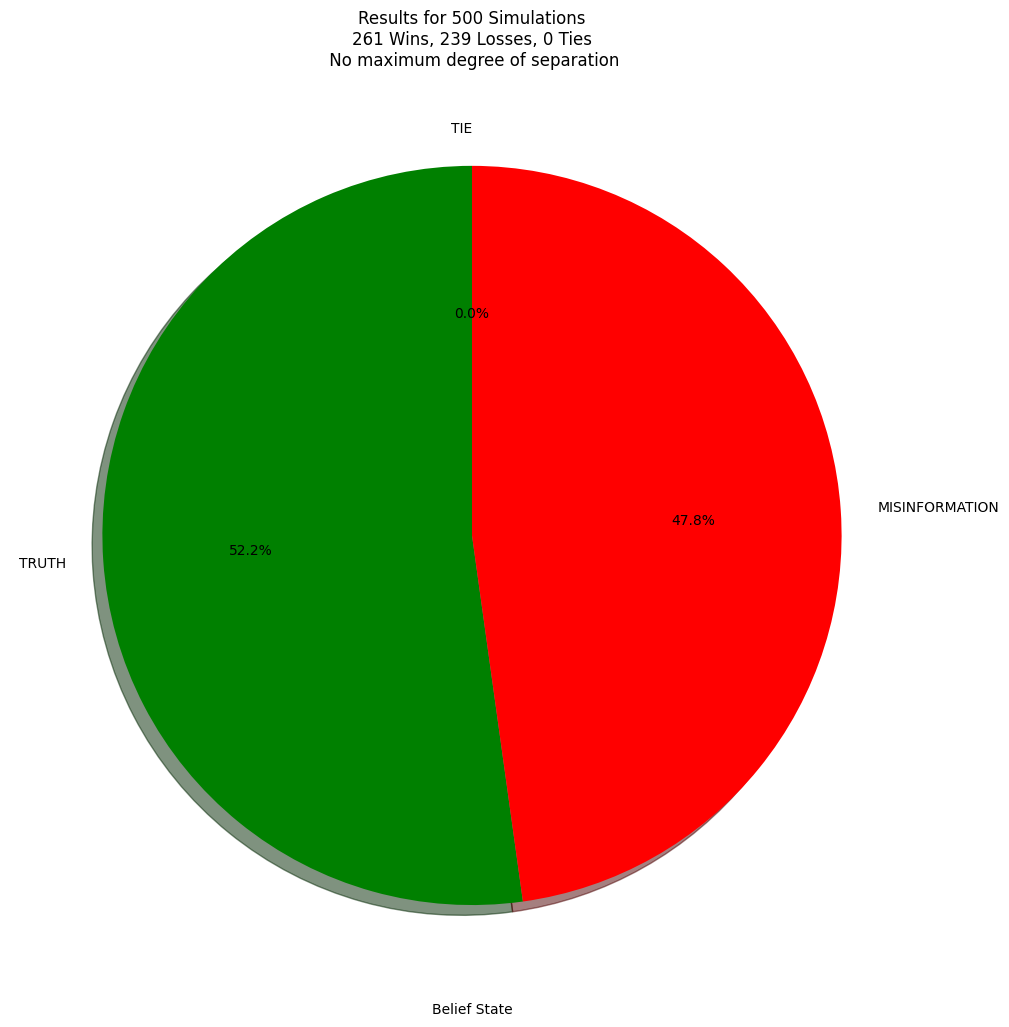

In [8]:
%matplotlib inline
history = []
num_to_add = 5
fig, ax1 = plt.subplots(ncols=1, figsize=(12,12))

num_of_simulations = 500

print("STARTING SIMULATION...")

win_record = {'TRUTH': 0, 'MISINFORMATION': 0, 'TIE': 0}
truth_count = 0
misinformation_count = 0
D_SEPARATION = 3

for sim in range(num_of_simulations):
    G = setup_graph(N=N, M=M, GOOD_ACTORS_CAP=GOOD_ACTORS_CAP, BAD_ACTORS_CAP=BAD_ACTORS_CAP, INFLUENCER_CAP=INFLUENCER_CAP)
    for i in range(simulation_steps):
        simulate_step(G, node_roles, history)

    for node in G.nodes():
        if G.nodes[node]['belief'] == 'TRUTH':
            truth_count += 1
        elif G.nodes[node]['belief'] == 'MISINFORMATION':
            misinformation_count += 1
    if truth_count > misinformation_count:
        win_record['TRUTH'] += 1
    elif truth_count < misinformation_count:
        win_record['MISINFORMATION'] += 1
    else:
        win_record['TIE'] += 1
    truth_count = 0
    misinformation_count = 0


print(win_record['TRUTH'])
print(win_record['MISINFORMATION'])
print(win_record['TIE'])
print(f"Number of nodes: {N}")

ax1.pie(win_record.values(), labels=win_record.keys(), autopct='%1.1f%%', shadow=True, startangle=90, colors=[color_map['TRUTH'], color_map['MISINFORMATION'], 'lightgray'])
ax1.set_title(f'Results for {num_of_simulations} Simulations\n{win_record["TRUTH"]} Wins, {win_record["MISINFORMATION"]} Losses, {win_record["TIE"]} Ties\n No maximum degree of separation')

ax1.set_xlabel('Belief State')
plt.show()

## 2. Intervention with Maximum Degree of Separation = 3

STARTING SIMULATION...
147
352
1


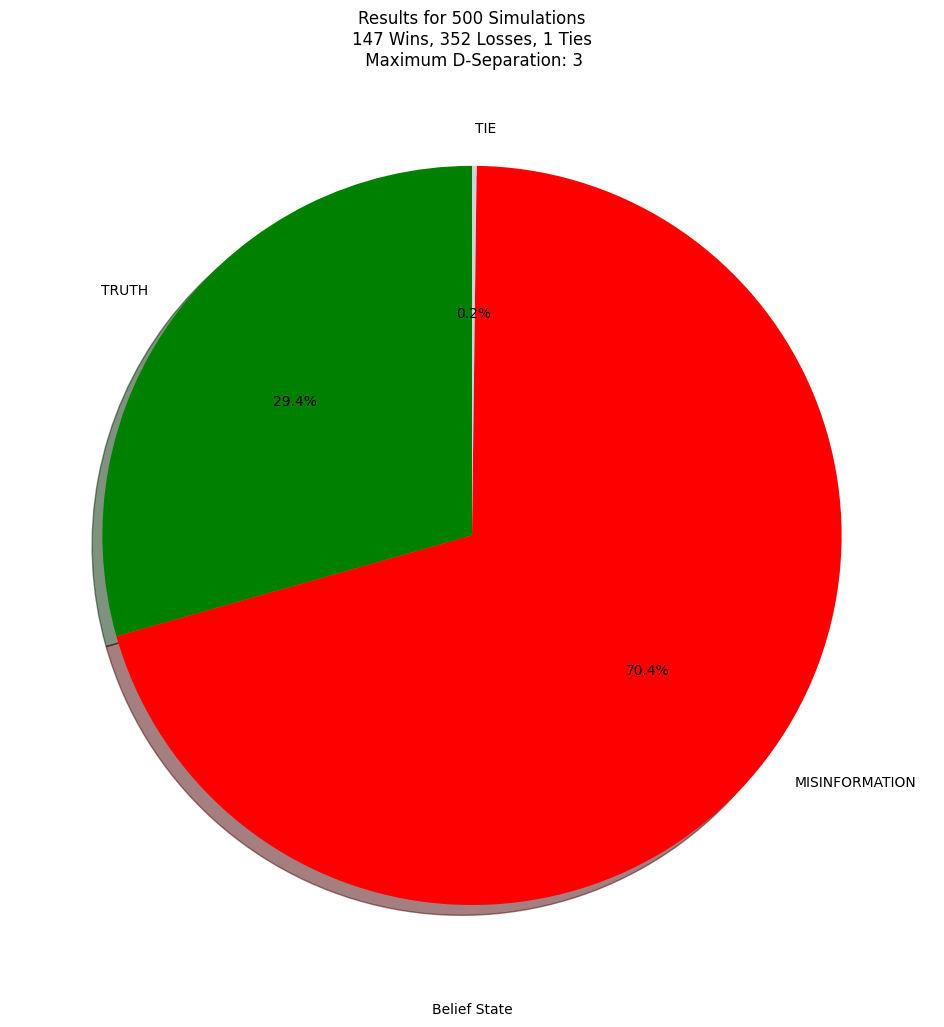

In [9]:
%matplotlib inline
history = []
num_to_add = 5
fig, ax1 = plt.subplots(ncols=1, figsize=(12,12))

num_of_simulations = 500

print("STARTING SIMULATION...")

win_record = {'TRUTH': 0, 'MISINFORMATION': 0, 'TIE': 0}
truth_count = 0
misinformation_count = 0
D_SEPARATION = 3

for sim in range(num_of_simulations):
    G = setup_graph(N=N, M=M, GOOD_ACTORS_CAP=GOOD_ACTORS_CAP, BAD_ACTORS_CAP=BAD_ACTORS_CAP, INFLUENCER_CAP=INFLUENCER_CAP, intervene=True)
    for i in range(simulation_steps):
        simulate_step(G, node_roles, history)

    for node in G.nodes():
        if G.nodes[node]['belief'] == 'TRUTH':
            truth_count += 1
        elif G.nodes[node]['belief'] == 'MISINFORMATION':
            misinformation_count += 1
    if truth_count > misinformation_count:
        win_record['TRUTH'] += 1
    elif truth_count < misinformation_count:
        win_record['MISINFORMATION'] += 1
    else:
        win_record['TIE'] += 1
    truth_count = 0
    misinformation_count = 0


print(win_record['TRUTH'])
print(win_record['MISINFORMATION'])
print(win_record['TIE'])
print(f"Number of nodes: {N}")

ax1.pie(win_record.values(), labels=win_record.keys(), autopct='%1.1f%%', shadow=True, startangle=90, colors=[color_map['TRUTH'], color_map['MISINFORMATION'], 'lightgray'])
ax1.set_title(f'Results for {num_of_simulations} Simulations\n{win_record["TRUTH"]} Wins, {win_record["MISINFORMATION"]} Losses, {win_record["TIE"]} Ties\n Maximum D-Separation: {D_SEPARATION}')

ax1.set_xlabel('Belief State')
plt.show()

## 3. Intervention with Maximum Degree of Separation = 2

STARTING SIMULATION...
213
285
2


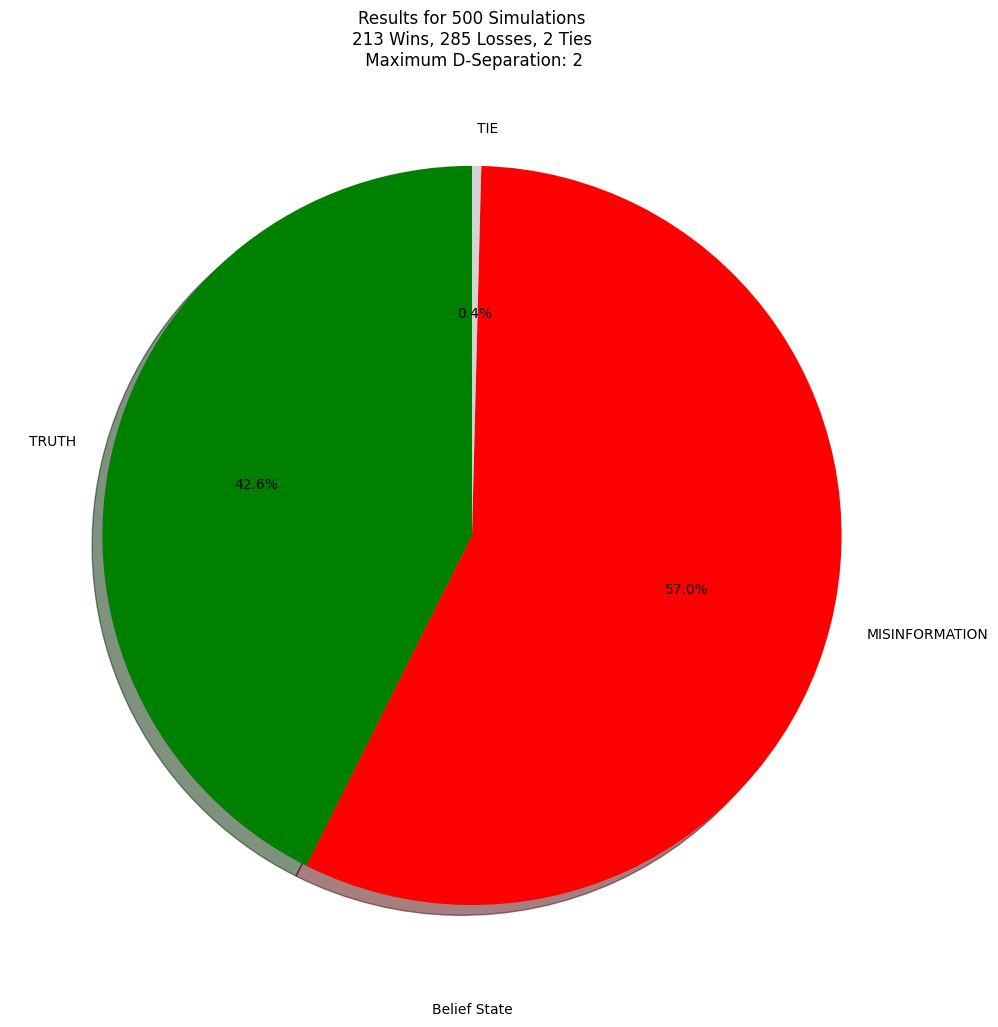

In [11]:
%matplotlib inline
history = []
num_to_add = 5
fig, ax1 = plt.subplots(ncols=1, figsize=(12,12))

num_of_simulations = 500

print("STARTING SIMULATION...")

win_record = {'TRUTH': 0, 'MISINFORMATION': 0, 'TIE': 0}
truth_count = 0
misinformation_count = 0
D_SEPARATION = 2

for sim in range(num_of_simulations):
    G = setup_graph(N=N, M=M, GOOD_ACTORS_CAP=GOOD_ACTORS_CAP, BAD_ACTORS_CAP=BAD_ACTORS_CAP, INFLUENCER_CAP=INFLUENCER_CAP, intervene=True)
    for i in range(simulation_steps):
        simulate_step(G, node_roles, history)

    for node in G.nodes():
        if G.nodes[node]['belief'] == 'TRUTH':
            truth_count += 1
        elif G.nodes[node]['belief'] == 'MISINFORMATION':
            misinformation_count += 1
    if truth_count > misinformation_count:
        win_record['TRUTH'] += 1
    elif truth_count < misinformation_count:
        win_record['MISINFORMATION'] += 1
    else:
        win_record['TIE'] += 1
    truth_count = 0
    misinformation_count = 0


print(win_record['TRUTH'])
print(win_record['MISINFORMATION'])
print(win_record['TIE'])
print(f"Number of nodes: {N}")

ax1.pie(win_record.values(), labels=win_record.keys(), autopct='%1.1f%%', shadow=True, startangle=90, colors=[color_map['TRUTH'], color_map['MISINFORMATION'], 'lightgray'])
ax1.set_title(f'Results for {num_of_simulations} Simulations\n{win_record["TRUTH"]} Wins, {win_record["MISINFORMATION"]} Losses, {win_record["TIE"]} Ties\n Maximum D-Separation: {D_SEPARATION}')

ax1.set_xlabel('Belief State')
plt.show()

## 4. Intervention with Maximum Degree of Separation = 1

STARTING SIMULATION...
332
168
0


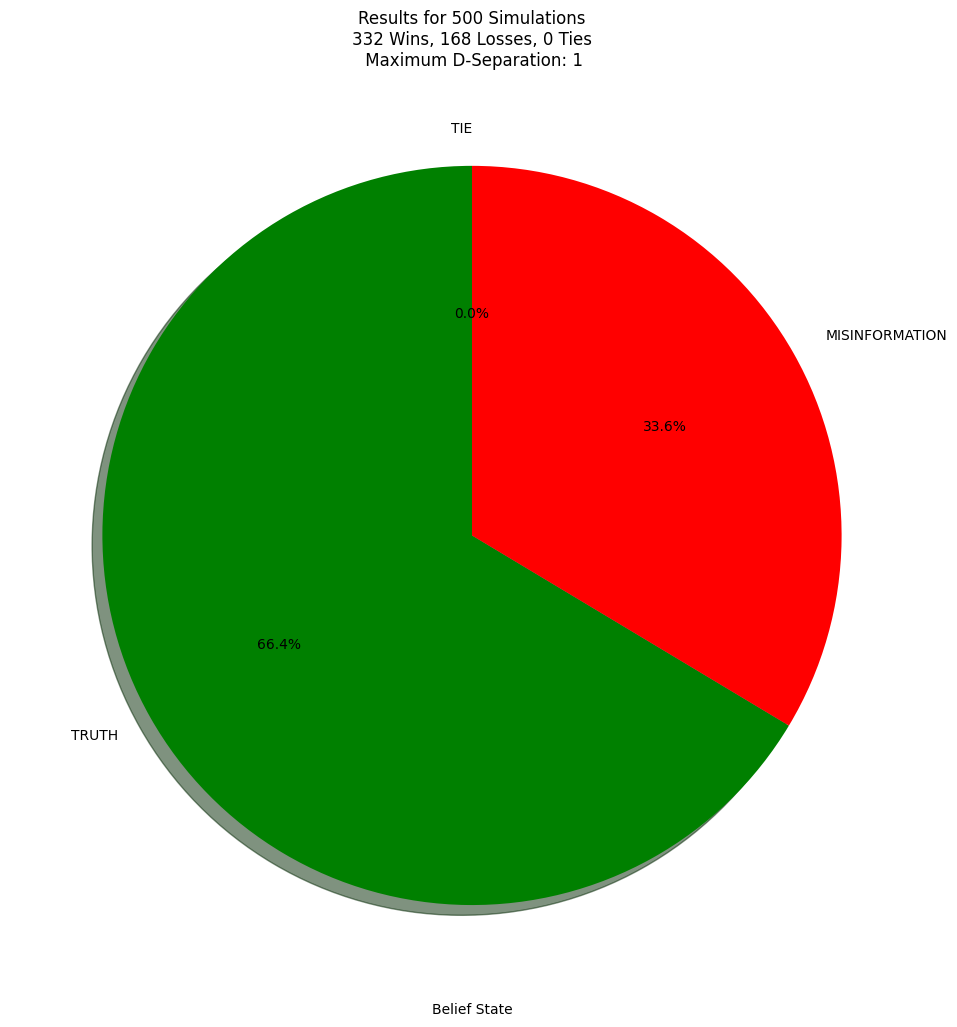

In [28]:
%matplotlib inline
history = []
num_to_add = 5
fig, ax1 = plt.subplots(ncols=1, figsize=(12,12))

num_of_simulations = 500

print("STARTING SIMULATION...")

win_record = {'TRUTH': 0, 'MISINFORMATION': 0, 'TIE': 0}
truth_count = 0
misinformation_count = 0
D_SEPARATION = 1

for sim in range(num_of_simulations):
    G = setup_graph(N=N, M=M, GOOD_ACTORS_CAP=GOOD_ACTORS_CAP, BAD_ACTORS_CAP=BAD_ACTORS_CAP, INFLUENCER_CAP=INFLUENCER_CAP, intervene=True)
    for i in range(simulation_steps):
        simulate_step(G, node_roles, history)

    for node in G.nodes():
        if G.nodes[node]['belief'] == 'TRUTH':
            truth_count += 1
        elif G.nodes[node]['belief'] == 'MISINFORMATION':
            misinformation_count += 1
    if truth_count > misinformation_count:
        win_record['TRUTH'] += 1
    elif truth_count < misinformation_count:
        win_record['MISINFORMATION'] += 1
    else:
        win_record['TIE'] += 1
    truth_count = 0
    misinformation_count = 0


print(win_record['TRUTH'])
print(win_record['MISINFORMATION'])
print(win_record['TIE'])
print(f"Number of nodes: {N}")

ax1.pie(win_record.values(), labels=win_record.keys(), autopct='%1.1f%%', shadow=True, startangle=90, colors=[color_map['TRUTH'], color_map['MISINFORMATION'], 'lightgray'])
ax1.set_title(f'Results for {num_of_simulations} Simulations\n{win_record["TRUTH"]} Wins, {win_record["MISINFORMATION"]} Losses, {win_record["TIE"]} Ties\n Maximum D-Separation: {D_SEPARATION}')

ax1.set_xlabel('Belief State')
plt.show()

STARTING SIMULATION...
393
107
0
Number of nodes: 1000


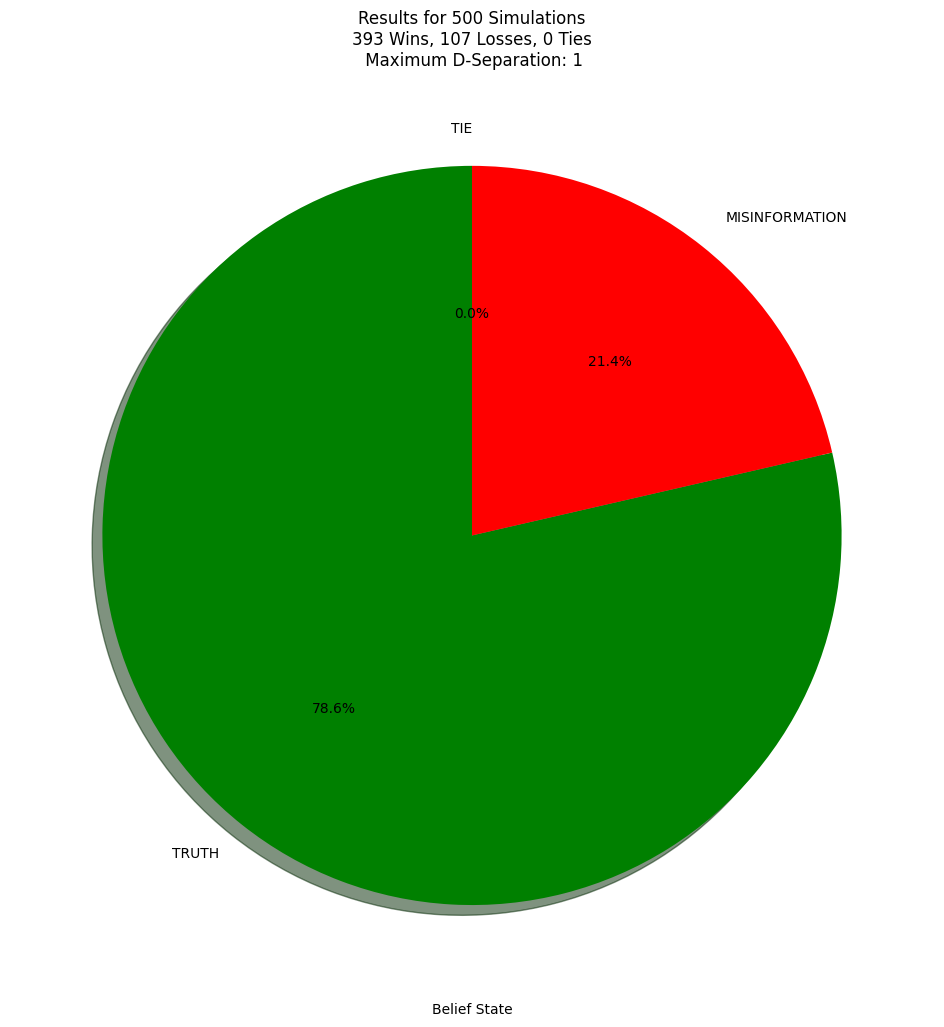

In [13]:
%matplotlib inline
history = []
num_to_add = 5
fig, ax1 = plt.subplots(ncols=1, figsize=(12,12))

num_of_simulations = 500

print("STARTING SIMULATION...")

win_record = {'TRUTH': 0, 'MISINFORMATION': 0, 'TIE': 0}
truth_count = 0
misinformation_count = 0
D_SEPARATION = 1

for sim in range(num_of_simulations):
    G = setup_graph(N=N * 10, M=M, GOOD_ACTORS_CAP=GOOD_ACTORS_CAP, BAD_ACTORS_CAP=BAD_ACTORS_CAP, INFLUENCER_CAP=INFLUENCER_CAP, intervene=True)
    for i in range(simulation_steps):
        simulate_step(G, node_roles, history)

    for node in G.nodes():
        if G.nodes[node]['belief'] == 'TRUTH':
            truth_count += 1
        elif G.nodes[node]['belief'] == 'MISINFORMATION':
            misinformation_count += 1
    if truth_count > misinformation_count:
        win_record['TRUTH'] += 1
    elif truth_count < misinformation_count:
        win_record['MISINFORMATION'] += 1
    else:
        win_record['TIE'] += 1
    truth_count = 0
    misinformation_count = 0


print(win_record['TRUTH'])
print(win_record['MISINFORMATION'])
print(win_record['TIE'])
print(f"Number of nodes: {N * 10}")

ax1.pie(win_record.values(), labels=win_record.keys(), autopct='%1.1f%%', shadow=True, startangle=90, colors=[color_map['TRUTH'], color_map['MISINFORMATION'], 'lightgray'])
ax1.set_title(f'Results for {num_of_simulations} Simulations\n{win_record["TRUTH"]} Wins, {win_record["MISINFORMATION"]} Losses, {win_record["TIE"]} Ties\n Maximum D-Separation: {D_SEPARATION}')

ax1.set_xlabel('Belief State')
plt.show()

STARTING SIMULATION...
153
347
0


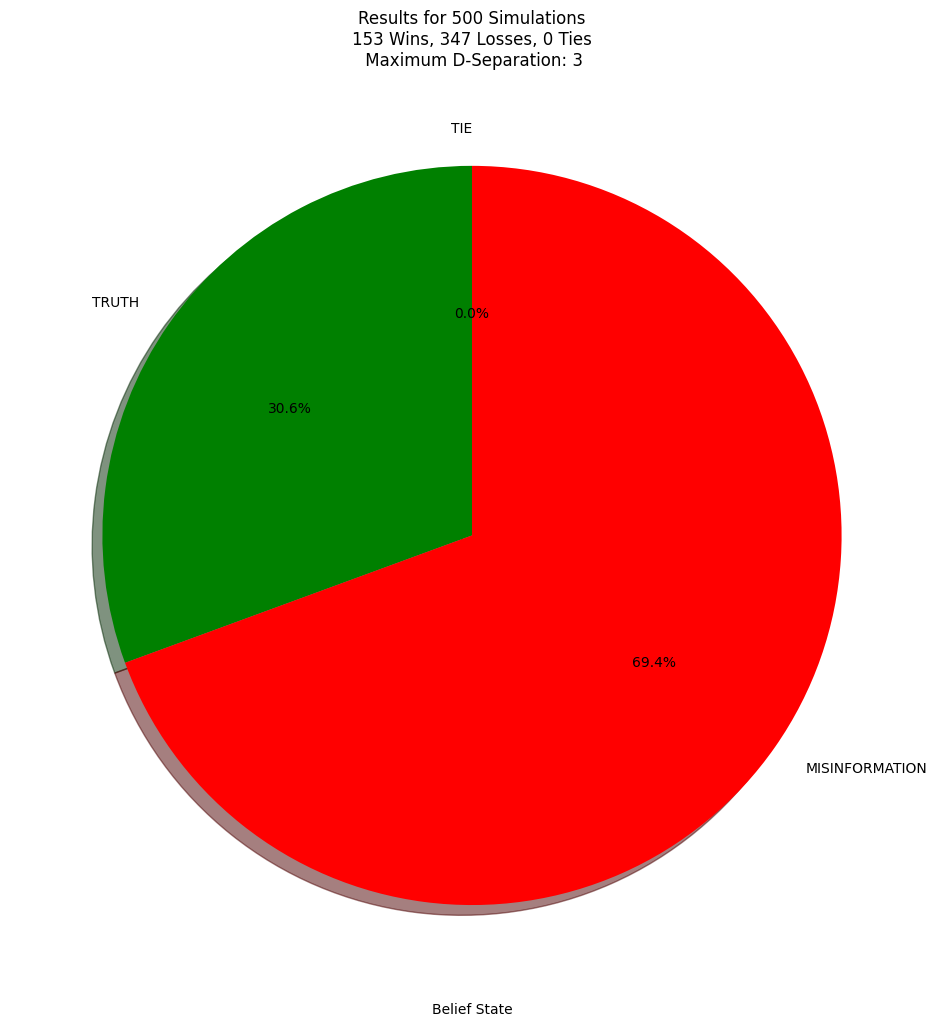

In [29]:
%matplotlib inline
history = []
num_to_add = 5
fig, ax1 = plt.subplots(ncols=1, figsize=(12,12))

num_of_simulations = 500

print("STARTING SIMULATION...")

win_record = {'TRUTH': 0, 'MISINFORMATION': 0, 'TIE': 0}
truth_count = 0
misinformation_count = 0
D_SEPARATION = 1

for sim in range(num_of_simulations):
    G = setup_graph(N=10000, M=M, GOOD_ACTORS_CAP=GOOD_ACTORS_CAP, BAD_ACTORS_CAP=BAD_ACTORS_CAP, INFLUENCER_CAP=INFLUENCER_CAP, intervene=True)
    for i in range(simulation_steps):
        simulate_step(G, node_roles, history)

    for node in G.nodes():
        if G.nodes[node]['belief'] == 'TRUTH':
            truth_count += 1
        elif G.nodes[node]['belief'] == 'MISINFORMATION':
            misinformation_count += 1
    if truth_count > misinformation_count:
        win_record['TRUTH'] += 1
    elif truth_count < misinformation_count:
        win_record['MISINFORMATION'] += 1
    else:
        win_record['TIE'] += 1
    truth_count = 0
    misinformation_count = 0


print(win_record['TRUTH'])
print(win_record['MISINFORMATION'])
print(win_record['TIE'])

ax1.pie(win_record.values(), labels=win_record.keys(), autopct='%1.1f%%', shadow=True, startangle=90, colors=[color_map['TRUTH'], color_map['MISINFORMATION'], 'lightgray'])
ax1.set_title(f'Results for {num_of_simulations} Simulations\n{win_record["TRUTH"]} Wins, {win_record["MISINFORMATION"]} Losses, {win_record["TIE"]} Ties\n Maximum D-Separation: {D_SEPARATION}')

ax1.set_xlabel('Belief State')
plt.show()

## Discussion of Intervention Results

The introduction of an intervention step in the simulation produces mixed results. In some runs, the intervention successfully thwarts the spread of misinformation, leading to a significant increase in the number of nodes adopting the truth. However, in other runs, the intervention does little to prevent the spread of misinformation.
To further analyze the effectiveness of interventions, multiple simulations were run, and the outcomes were recorded.

# Bibliography

Watts, D. J., & Strogatz, S. H. (1998). Collective dynamics of ‘small-world’ networks. Nature, 393(6684), 440–442. https://doi.org/10.1038/30918

Barabási, A.-L., & Albert, R. (1999). Emergence of Scaling in Random Networks. Science, 286(5439), 509–512. https://doi.org/10.1126/science.286.5439.509